# Sunspot prediction using  time series structured data
This notebook uses concepts from fastAIs DL1 course to estimate sunspot activity using a 2 layer fully connected neurel net.<br>This notebook derives from this post https://medium.com/38th-street-studios/time-series-with-structured-deep-learning-e911c1ef9923

In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Get the data
comes from https://datamarket.com/data/set/22ti/zuerich-monthly-sunspot-numbers-1749-1983#!ds=22ti&display=line<br>
in ../data folder<br>

In [20]:
# get the data, first row [0] is column names
import pandas as pd
df = pd.read_csv("./data/sunspot/zuerich-monthly-sunspot-numbers.csv",header=0 )

In [21]:
df.columns = ['Month', 'SunspotNumbs']

In [22]:
df.head()

,Month,SunspotNumbs
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


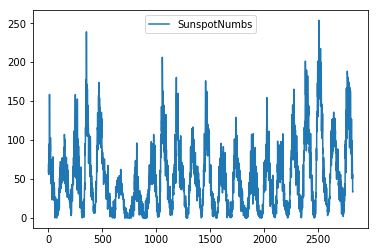

In [23]:
#view it
import matplotlib.pyplot as plt
df.plot()

# convert date time
The last line in the csv file is a summary, please remove it before running this operation

In [24]:

from fastai.structured import *
from fastai.column_data import *
#Convert our date column to a pandas datetime Series
df["Date"] = pd.to_datetime(df["Month"], format='%Y-%m')
#Create date features
add_datepart(df,"Date")

In [25]:
df.describe()

,Month,SunspotNumbs,Year,Week,Day,Dayofweek,Dayofyear,Elapsed
count,2820.000000,2820.000000,2820.000000,2820.000000,2820.0,2820.000000,2820.000000,2.820000e+03
mean,6.500000,51.265957,1866.000000,26.246099,1.0,3.000709,167.698582,-3.267523e+09
std,3.452665,43.448971,67.850074,15.128927,0.0,2.000177,105.088786,2.141145e+09
min,1.000000,0.000000,1749.000000,1.000000,1.0,0.000000,1.000000,-6.974035e+09
25%,3.750000,15.700000,1807.000000,13.000000,1.0,1.000000,83.500000,-5.120885e+09
50%,6.500000,42.000000,1866.000000,26.000000,1.0,3.000000,167.500000,-3.267562e+09
75%,9.250000,74.925000,1925.000000,40.000000,1.0,5.000000,252.250000,-1.414303e+09
max,12.000000,253.800000,1983.000000,53.000000,1.0,6.000000,336.000000,4.390848e+08


In [26]:
#see all the values, just need 2 year and month
df.columns.values

array(['Month', 'SunspotNumbs', 'Year', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
       'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype=object)

In [27]:
df.dtypes

Month                 int64
SunspotNumbs        float64
Year                  int64
Week                  int64
Day                   int64
Dayofweek             int64
Dayofyear             int64
Is_month_end           bool
Is_month_start         bool
Is_quarter_end         bool
Is_quarter_start       bool
Is_year_end            bool
Is_year_start          bool
Elapsed               int64
dtype: object

In [28]:
# get rid of useless columns
df=df.drop(['Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Elapsed'],axis=1)

In [29]:
#lets create num_lags additional columns, for each row these columns will hold 
#SunspotNumbst-1, SunspotNumbst-2 etc
num_lags = 12

## These 2 cells do the same thing
Ones a bit easier to read and a bit slower

In [30]:
# %%timeit
# for i in range(1,num_lags+1):
#     df[f'lag_{i}'] = np.append([np.nan for j in range(0,i)],df['SunspotNumbs'])[:-i]

#for each row, convert all NANs to either Sunspot val or last lag_n that is not a NaN

In [31]:
%%timeit
df[f'lag_1'] =  df['SunspotNumbs'].shift(1)
for i in range(2,num_lags+1):
    df[f'lag_{i}'] = df[f'lag_{i-1}'].shift(1)

#for each row, convert all NANs to either Sunspot val or last lag_n that is not a NaN

1.55 ms ± 2.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
#what does it look like?
df[0:300].T

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
Month,1,2,3,4,5,6,7,8,9,10,...,3,4,5,6,7,8,9,10,11,12
SunspotNumbs,58,62.6,70,55.7,85,83.5,94.8,66.3,75.9,75.5,...,51.2,32.9,41.1,28.4,27.7,12.7,29.3,26.3,40.9,43.2
Year,1749,1749,1749,1749,1749,1749,1749,1749,1749,1749,...,1773,1773,1773,1773,1773,1773,1773,1773,1773,1773
Dayofyear,1,32,60,91,121,152,182,213,244,274,...,60,91,121,152,182,213,244,274,305,335
Is_quarter_end,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Is_quarter_start,True,False,False,True,False,False,True,False,False,True,...,False,True,False,False,True,False,False,True,False,False
Is_year_end,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Is_year_start,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
lag_1,NaN,58,62.6,70,55.7,85,83.5,94.8,66.3,75.9,...,29,51.2,32.9,41.1,28.4,27.7,12.7,29.3,26.3,40.9
lag_2,NaN,NaN,58,62.6,70,55.7,85,83.5,94.8,66.3,...,54.6,29,51.2,32.9,41.1,28.4,27.7,12.7,29.3,26.3


# Convert column types to category and float32

In [33]:
contin_vars = [f"lag_{i}" for i in range(1,num_lags+1)]
cat_vars = ["Year","Month","Dayofyear","Is_quarter_end","Is_quarter_start","Is_year_end","Is_year_start"]
dep = "SunspotNumbs"

#convert categorical to category type
for v in cat_vars: df[v] = df[v].astype('category').cat.as_ordered()
    
#make float32 since thats what pyTorch expects
for v in contin_vars: df[v] = df[v].astype('float32')

In [34]:
df.dtypes

Month               category
SunspotNumbs         float64
Year                category
Dayofyear           category
Is_quarter_end      category
Is_quarter_start    category
Is_year_end         category
Is_year_start       category
lag_1                float32
lag_2                float32
lag_3                float32
lag_4                float32
lag_5                float32
lag_6                float32
lag_7                float32
lag_8                float32
lag_9                float32
lag_10               float32
lag_11               float32
lag_12               float32
dtype: object

# Split df to train, val, test

In [35]:
train_ratio = 0.6
val_ratio = 0.15
test_ratio = 0.25

#lets get a list of the indices of the entries I want in validation set
#its time series so make it at the end
numb_rows = len(df)

#get the validation portion of df
val_start = int(train_ratio*(float(numb_rows)))
val_end = int((train_ratio+ val_ratio)*(float(numb_rows)))
val_idx = list(range(val_start,val_end ))

#split out train-val df
df_trn_val = df[:val_end].copy()

#split out test df
df_test = df[val_end:].copy()

## operate on train and test sets
note that Im using the mapper and nas_trn_val from first proc_df to get the appropriate mean and std_dev and nas columns from trn_val set to use on test set 

In [36]:
#df, y, nas, mapper = proc_df(df_samp, 'SunspotNumbs', do_scale=True)
df_trn_val, yl_trn_val, nas_trn_val, mapper = proc_df(df=df_trn_val, y_fld='SunspotNumbs',do_scale=True)

#use the above mapper and nas_trn_val for normalization
df_test, yl_test, nas_test, _ = proc_df(df=df_test, y_fld='SunspotNumbs',do_scale=True, mapper =mapper, na_dict=nas_trn_val )

#first lets make sure we never take ln of 0 (-infinity) by adding a small value to y
yl_trn_val = np.log(yl_trn_val + 0.01)
yl_test = np.log(yl_test + 0.01)

In [37]:
#whats in here?
mapper

DataFrameMapper(default=False, df_out=False,
        features=[(['lag_1'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['lag_2'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['lag_3'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['lag_4'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['lag...an=True, with_std=True)), (['lag_12_na'], StandardScaler(copy=True, with_mean=True, with_std=True))],
        input_df=False, sparse=False)

In [38]:
#nas will tell you the median value that is used to replace NaN's for every column with a NaN
# you can run the following command on column lag_1 to verify
#df_trn_val.lag_1.median()
nas_trn_val 

{'lag_1': 37.849998474121094,
 'lag_2': 37.900001525878906,
 'lag_3': 37.95000076293945,
 'lag_4': 38.0,
 'lag_5': 38.0,
 'lag_6': 38.0,
 'lag_7': 38.0,
 'lag_8': 38.0,
 'lag_9': 38.0,
 'lag_10': 38.0,
 'lag_11': 38.0,
 'lag_12': 38.0}

In [39]:
#nas will tell you the median value that is used to replace NaN's for every column with a NaN
#df.lag_1.median()
#nas_test 

In [40]:
#note all the lag_i_na columns
#df_trn_val.head().T

In [41]:
#what does target look like
#len(y)
yl_trn_val

array([4.06062, 4.13693, 4.24864, ..., 1.70656, 3.14458, 2.89093])

In [42]:
df_test.columns

Index(['Month', 'Year', 'Dayofyear', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_1_na', 'lag_2_na', 'lag_3_na', 'lag_4_na', 'lag_5_na',
       'lag_6_na', 'lag_7_na', 'lag_8_na', 'lag_9_na', 'lag_10_na',
       'lag_11_na', 'lag_12_na'],
      dtype='object')

In [43]:
#get rid of the lag_n_na fields
def dump_na_columns(df1):   
    for i in range(1,13):
        try:
            df1.drop(f'lag_{i}_na',axis=1,inplace=True)
        except ValueError as e:
            print('ValueError:{0}'.format(e))
dump_na_columns(df_trn_val)
dump_na_columns(df_test)

In [44]:
print( "Rows in df_trn_val=" + str(len(df_trn_val)))
print( "Rows in df_test   =" + str(len(df_test)))

Rows in df_trn_val=2115
Rows in df_test   =705


# Adjust column types
Convert all categorical columns to 'category' and continuous variables to 'float32' (for pytorch)

In [45]:
 #what kind are they now?
df_trn_val.dtypes
df_test.dtypes

Month                  int8
Year                  int16
Dayofyear              int8
Is_quarter_end         int8
Is_quarter_start       int8
Is_year_end            int8
Is_year_start          int8
lag_1               float64
lag_2               float64
lag_3               float64
lag_4               float64
lag_5               float64
lag_6               float64
lag_7               float64
lag_8               float64
lag_9               float64
lag_10              float64
lag_11              float64
lag_12              float64
dtype: object

In [46]:
for v in cat_vars: 
    df_trn_val[v] = df_trn_val[v].astype('category').cat.as_ordered()
    df_test[v] = df_test[v].astype('category').cat.as_ordered()

for v in contin_vars: 
    df_trn_val[v] = df_trn_val[v].astype('float32')
    df_test[v] = df_test[v].astype('float32')

# Verify no nulls

In [47]:
print( "Nulls in df_trn_val=" + str(df_trn_val.isnull().sum().sum()))
print( "Nulls in df_test   =" + str(df_test.isnull().sum().sum()))

print( "Rows in df_trn_val=" + str(len(df_trn_val)))
print( "Rows in df_test   =" + str(len(df_test)))

print( "Rows in yl_trn_val=" + str(len(yl_trn_val)))
print( "Rows in yl_test   =" + str(len(yl_test)))

Nulls in df_trn_val=0
Nulls in df_test   =0
Rows in df_trn_val=2115
Rows in df_test   =705
Rows in yl_trn_val=2115
Rows in yl_test   =705


# Save the data
side effect: df_test starts at index ~2300, the following will reset its index to 0 

In [48]:
PATH = "./data/SS_Data"

#needed for feather, do not add index column
df_trn_val.reset_index(drop = True,inplace = True)
df_test.reset_index(drop = True,inplace = True)

#save train and test dataframes
df_trn_val.to_feather(f'{PATH}/df_trn_val')
df_test.to_feather(f'{PATH}/df_test')

#save tran and test dependant nparray
np.save(f'{PATH}/yl_trn_val', yl_trn_val)    # .npy extension is added if not given
np.save(f'{PATH}/yl_test', yl_test)    

# Reload the processed dataframes and the numpy target arrays

In [49]:
#reload
df_trn_val = pd.read_feather(f'{PATH}/df_trn_val')
df_test = pd.read_feather(f'{PATH}/df_test')

yl_trn_val  = np.load(f'{PATH}/yl_trn_val.npy')
yl_test  = np.load(f'{PATH}/yl_test.npy')

# Create model data object

In [50]:
def inv_y(a): return np.exp(a)
def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())
def mse(y_pred, targ):
    targ = inv_y(targ)
    y_pred = inv_y(y_pred)
    return math.sqrt(((y_pred-targ)**2).mean())
max_log_y = np.max(yl_trn_val)
y_range = (0, max_log_y*1.2)

In [51]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df_trn_val, yl_trn_val.astype(np.float32), cat_flds=cat_vars, bs=16, test_df = df_test)

In [73]:
#get categorical sizes, make sure you convert columns in cat_vars to type category before you run this 
#make sure you include all the years! including the possibilities from your test set see the df not df_trn_val below
# cat_sz = [(c, len(df_trn_val[c].cat.categories)+1) for c in cat_vars]
cat_sz = [(c, len(df[c].cat.categories)+1) for c in cat_vars]

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [74]:
# cat_sz[0] = (191, 50)
cat_sz

[('Year', 178),
 ('Month', 13),
 ('Dayofyear', 23),
 ('Is_quarter_end', 2),
 ('Is_quarter_start', 3),
 ('Is_year_end', 2),
 ('Is_year_start', 3)]

In [65]:
emb_szs

[(236, 50), (13, 7), (23, 12), (2, 1), (3, 2), (2, 1), (3, 2)]

In [66]:
cat_sz

[('Year', 236),
 ('Month', 13),
 ('Dayofyear', 23),
 ('Is_quarter_end', 2),
 ('Is_quarter_start', 3),
 ('Is_year_end', 2),
 ('Is_year_start', 3)]

In [67]:
emb_szs

[(236, 50), (13, 7), (23, 12), (2, 1), (3, 2), (2, 1), (3, 2)]

epoch      trn_loss   val_loss                              
    0      7.827887   11.344112 



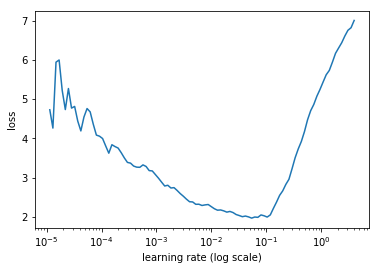

In [68]:
m = md.get_learner(emb_szs, len(df_trn_val.columns)-len(cat_vars),0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.lr_find()
m.sched.plot(1)

In [69]:
lr = 20e-5

# m.fit(lr, 2, metrics=[exp_rmspe,mse], cycle_len=1, cycle_mult=2)
m.fit(lr, n_cycle = 3, metrics=[exp_rmspe,mse], cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   exp_rmspe  mse             
    0      1.884211   1.070309   13.969527  15.596442 
    1      1.537871   1.093903   12.026483  15.369704       
    2      1.421104   1.120002   10.10968   15.511403       
    3      1.414237   1.057125   10.404155  15.093958       
    4      1.408361   1.017487   11.040147  14.810769       
    5      1.386295   1.001281   11.516381  14.618231       
    6      1.323476   1.000189   11.319086  14.912874       
    7      1.152384   0.970518   12.307002  14.449672       
    8      1.258779   1.143809   9.167661   16.405707       
    9      1.169537   1.073984   10.17004   15.624793       
    10     1.151154   1.020657   10.780853  15.032033       
    11     1.240495   1.067686   9.643145   15.017051        
    12     1.045418   1.066821   9.664573   15.118957       
    13     1.180384   1.07154    9.641837   15.209025       



[array([1.07154]), 9.64183662125031, 15.209025384938895]

# Save model parameters

In [70]:
#saves it to wherever PATH points in original model object
m.save(f'val1')
m.load(f'val1')

# Lets run some predictions, first on the validation then on the test data


In [117]:
#calling predict will return predictions from the validation set
predictions_validation = m.predict()

the learner has never seen df_test values

In [118]:
#create ColumnarDataSet from DataFrame (df)
ctest = ColumnarDataset.from_data_frame(df_test,cat_flds=cat_vars)

# create DataLoader from ColumnarDataSet
dl_test = DataLoader(ctest)

# make predictions for DataLoader
predictions_test = m.predict_dl(dl_test)

## Calculate final values for display

In [119]:
#actual
actual = np.append([np.exp(yl_trn_val)],[np.exp(yl_test)])

#validation(bunch of NaNs, val results, bunch of NaNs)
validation = np.append([  np.append([np.full(val_start,np.nan)],[np.exp(predictions_validation)])  ],[np.full(len(predictions),np.nan)])

#test(bunch of NaNs,bunch of NaNs, val results )
test = np.append([np.full(len(df_trn_val),np.nan)],[np.exp(predictions_test)])

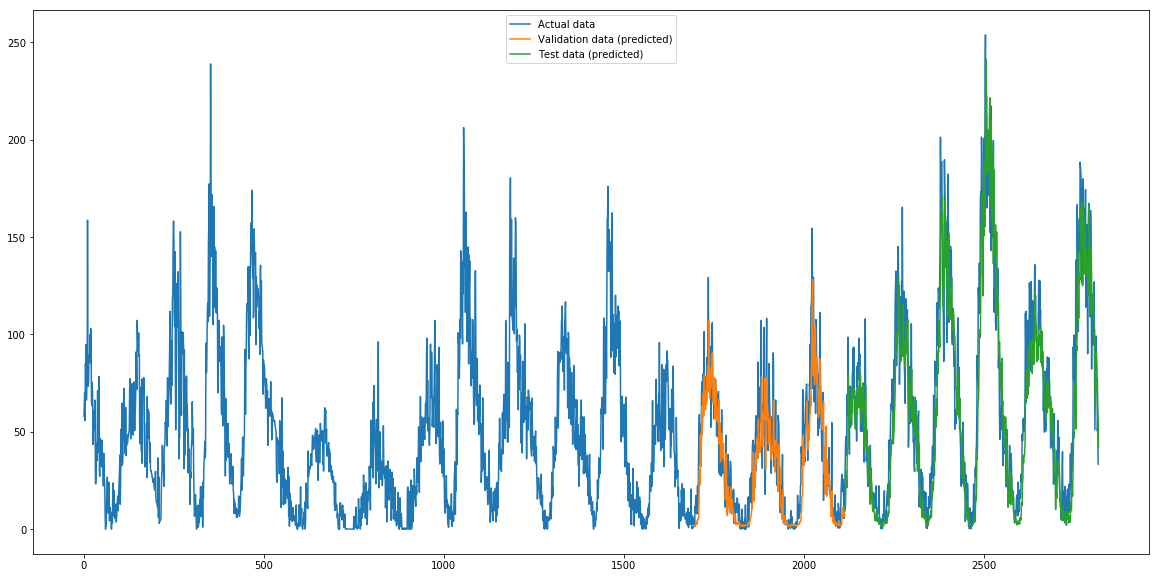

In [131]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(actual,label='Actual data')
plt.plot(validation, label='Validation data (predicted)')
plt.plot(test,label='Test data (predicted)')
plt.legend(loc='upper center');
plt.show()